# Assignment 1

**Q1) Given a dataset where 80% is to be used for training and 20% for testing, with the training data being annotated and unannotated. First implement the Baum-Welch algorithm to train a Hidden Markov Model (HMM) on the unannotated data. Then, apply the Viterbi algorithm to predict sequences on both the unannotated and the annotated training data. Finally, evaluate the model's performance by testing it on the 20% test data. After that repeat the same process for annotated training data (here baum welch is not necessary as you can directly apply viterbi algorithm). Compare the performances for both the processes.**

**Annotated Corpus :**  https://github.com/qanastek/ANTILLES/blob/main/ANTILLES/test.conllu

**Un-annotated Corpus :**  https://wortschatz.uni-leipzig.de/en/download/French

**For un-annotated corpus you can download 10k sentences for training.**

**Use the test data from the annotated corpus so that you can evaluate the performances.**

**Use same set of tags for training on unannotated as well as annotated corpus.**

In [5]:
!pip install wget conllu nltk hmmlearn pomegranate -q scikit-learn

## Custom Implementation: The Issue Faced during this implementation was that either it was taking a lot of time or the values were converging to NaN or 0.

In [6]:
# Import necessary libraries
import nltk
import wget
import conllu
import numpy as np
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import os

# Install the necessary resources for NLTK
nltk.download('universal_tagset')
nltk.download('punkt')
# Define file paths
annotated_url = "https://github.com/qanastek/ANTILLES/raw/main/ANTILLES/test.conllu"
annotated_filename = "test.conllu"

# Download annotated corpus
if not os.path.exists(annotated_filename):
    wget.download(annotated_url, annotated_filename)

# Load and parse the annotated corpus
try:
    with open(annotated_filename, "r", encoding="utf-8") as f:
        annotated_data = conllu.parse(f.read())
    print("Successfully parsed annotated data.")
except Exception as e:
    print(f"Failed to parse CoNLL-U data: {e}")

# Extract words and tags
words = []
tags = []
for sentence in annotated_data:
    for token in sentence:
        words.append(token['form'])
        tags.append(token['upostag'])

# Create dictionaries for words and tags
word_to_idx = {word: idx for idx, word in enumerate(set(words))}
tag_to_idx = {tag: idx for idx, tag in enumerate(set(tags))}

# Convert sentences to indices
def sentence_to_indices(sentence):
    return [word_to_idx.get(word, -1) for word in sentence]

annotated_sentences = []
annotated_tags = []
for sentence in annotated_data:
    words = [token['form'] for token in sentence]
    tags = [token['upostag'] for token in sentence]
    annotated_sentences.append(sentence_to_indices(words))
    annotated_tags.append([tag_to_idx[tag] for tag in tags])

X_train_annotated, X_test_annotated, y_train_annotated, y_test_annotated = train_test_split(
    annotated_sentences, annotated_tags, test_size=0.2, random_state=42
)

print( len(X_train_annotated), len(y_test_annotated) )

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Successfully parsed annotated data.
332 84


In [7]:
import pandas as pd
import numpy as np


def forward(V, a, b, initial_distribution):
    alpha = np.zeros((V.shape[0], a.shape[0]))
    alpha[0, :] = initial_distribution * b[:, V[0]]

    for t in range(1, V.shape[0]):
        for j in range(a.shape[0]):
            alpha[t, j] = alpha[t - 1].dot(a[:, j]) * b[j, V[t]]
    return alpha


def backward(V, a, b):
    beta = np.zeros((V.shape[0], a.shape[0]))
    beta[V.shape[0] - 1] = np.ones((a.shape[0]))

    for t in range(V.shape[0] - 2, -1, -1):
        for j in range(a.shape[0]):
            beta[t, j] = (beta[t + 1] * b[:, V[t + 1]]).dot(a[j, :])
    return beta


def baum_welch(V, a, b, initial_distribution, n_iter=100):
    M = a.shape[0]
    T = len(V)

    for n in range(n_iter):
        alpha = forward(V, a, b, initial_distribution)
        beta = backward(V, a, b)
        xi = np.zeros((M, M, T - 1))
        for t in range(T - 1):
            denominator = np.dot(np.dot(alpha[t, :].T, a) * b[:, V[t + 1]].T, beta[t + 1, :])
            for i in range(M):
                numerator = alpha[t, i] * a[i, :] * b[:, V[t + 1]].T * beta[t + 1, :].T
                xi[i, :, t] = numerator / ( denominator + 0.1)

        gamma = np.sum(xi, axis=1)
        a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))

        gamma = np.hstack((gamma, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))

        K = b.shape[1]
        denominator = np.sum(gamma, axis=1)
        for l in range(K):
            b[:, l] = np.sum(gamma[:, V == l], axis=1)

        b = np.divide(b, denominator.reshape((-1, 1)))

    return {"a":a, "b":b}

# data loading
unique_words= set({})
# data_sen.txt is the fra_mixed_2009_10K-sentences.txt file
with open("data_sen.txt", "r") as fil:
  for line in fil:
    words= line.split()
    for word in words:
      unique_words.add(word)

word_to_index = {word: idx for idx, word in enumerate(unique_words)}
M = len(annotated_tags)
K = len(unique_words)

with open("data_sen.txt", "r") as file:
    lines = file.readlines()

# taking only 64 sentences initially
temp= lines[:64]
A = np.ones((M, M)) / M
B = np.ones((M, K)) / K
initial_distribution = np.ones(M) / M

# Process each line individually
results = []
for line in temp:
  words = line.strip().split()
  v = np.array([word_to_index[word] for word in words])

  # Run Baum-Welch on the current line
  result = baum_welch(v, A, B, initial_distribution, n_iter=1)
  results.append(result)


<ipython-input-7-c572614529e3>:40: RuntimeWarning: invalid value encountered in divide
  a = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))
<ipython-input-7-c572614529e3>:49: RuntimeWarning: invalid value encountered in divide
  b = np.divide(b, denominator.reshape((-1, 1)))


## Implementing through hmmlearn library which uses baum-welch `forward-backward algorithm` in its `MultinomialHMM` algorithm to train an HMM model.

In [8]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.metrics import classification_report
from conllu import parse
from collections import defaultdict
from sklearn.model_selection import train_test_split
import nltk
import os
import wget

def load_annotated_corpus(file_path):
    with open(file_path, "r") as file:
        data = parse(file.read())
    sentences, tags = [], []
    for sentence in data:
        words, sentence_tags = [], []
        for token in sentence:
            words.append(token['form'])
            sentence_tags.append(token['upostag'])
        sentences.append(words)
        tags.append(sentence_tags)
    return sentences, tags

def tokenize_unannotated_data(file_path, vocab, num_sentences=10000):
    sentences = []
    unknown_index = len(vocab)
    with open(file_path, "r") as file:
        for i, line in enumerate(file):
            if i >= num_sentences:
                break
            words = line.strip().split()
            sentence = [vocab[word] if word in vocab else unknown_index for word in words]
            if sentence:
                sentences.append(sentence)
    return sentences

def build_vocab(sentences):
    vocab = defaultdict(lambda: len(vocab))
    for sentence in sentences:
        for word in sentence:
            vocab[word]
    return vocab

def train_hmm_unannotated(sentences, num_tags):
    model = hmm.MultinomialHMM(n_components=num_tags, n_iter=100)

    X = np.concatenate([np.array(sentence) for sentence in sentences])
    X = X.reshape(-1, 1)
    lengths = [len(sentence) for sentence in sentences]

    model.fit(X, lengths)
    return model

def predict_viterbi(model, sentences):
    predictions = []
    for sentence in sentences:
        X = np.array(sentence).reshape(-1, 1)
        _, state_sequence = model.decode(X)
        predictions.append(state_sequence.tolist())
    return predictions

def map_predictions_to_tags(predicted_tags, tag_map):
    return [[tag_map[tag] for tag in sentence] for sentence in predicted_tags]

def evaluate_predictions(true_tags, predicted_tags):
    flat_true = []
    flat_pred = []

    for true_sentence, pred_sentence in zip(true_tags, predicted_tags):
        if len(true_sentence) != len(pred_sentence):
            continue
        flat_true.extend(true_sentence)
        flat_pred.extend(pred_sentence)

    df = pd.DataFrame({
        'True Tags': flat_true,
        'Predicted Tags': flat_pred
    })

    df['Predicted Tags'] = df['Predicted Tags'].astype(str)
    print(classification_report(df['True Tags'], df['Predicted Tags'], zero_division=1) )

# Install the necessary resources for NLTK
nltk.download('universal_tagset')
nltk.download('punkt')

# Define file paths
annotated_url = "https://github.com/qanastek/ANTILLES/raw/main/ANTILLES/test.conllu"
annotated_filename = "test.conllu"

# Download annotated corpus
if not os.path.exists(annotated_filename):
    wget.download(annotated_url, annotated_filename)

# Load annotated data
annotated_sentences, annotated_tags = load_annotated_corpus('/content/test.conllu')
vocab = build_vocab(annotated_sentences)

unannotated_sentences = tokenize_unannotated_data('/content/data_sen.txt', vocab)

annotated_train_sents, annotated_test_sents, annotated_train_tags, annotated_test_tags = train_test_split(annotated_sentences, annotated_tags, test_size=0.2, random_state=42)
unannotated_train_sents, unannotated_test_sents = train_test_split(unannotated_sentences, test_size=0.2, random_state=42)

# Train HMM on unannotated data (Baum-Welch)
hmm_model_unannotated = train_hmm_unannotated(unannotated_train_sents, num_tags=40)
annotated_train_sents_indices = [[vocab[word] for word in sentence] for sentence in annotated_train_sents]
annotated_test_sents_indices = [[vocab[word] for word in sentence] for sentence in annotated_test_sents]

# Predicting on the data
predicted_unannotated = predict_viterbi(hmm_model_unannotated, unannotated_test_sents)
predicted_annotated_untrained = predict_viterbi(hmm_model_unannotated, annotated_test_sents_indices)

tag_map = {i: tag for i, tag in enumerate(set(np.concatenate(annotated_train_tags)))}  # Generate tag map
predicted_annotated_untrained_mapped = map_predictions_to_tags(predicted_annotated_untrained, tag_map)
print("Evaluation of HMM (trained on unannotated data) on annotated test set:")
evaluate_predictions(annotated_test_tags, predicted_annotated_untrained_mapped)

# Train HMM on annotated data (Baum-Welch training), it can also be done that we are not using the baum-welch algorithm but both approaches should work
hmm_model_annotated = hmm.MultinomialHMM(n_components=10, n_iter=100)
X_annotated_train = np.concatenate(annotated_train_sents_indices).reshape(-1, 1)
lengths_annotated_train = [len(sentence) for sentence in annotated_train_sents_indices]
hmm_model_annotated.fit(X_annotated_train, lengths_annotated_train)

# Predict using Viterbi on the annotated test data
predicted_annotated_trained = predict_viterbi(hmm_model_annotated, annotated_test_sents_indices)
predicted_annotated_trained_mapped = map_predictions_to_tags(predicted_annotated_trained, tag_map)
print("Evaluation of HMM (trained on annotated data) on annotated test set:")
evaluate_predictions(annotated_test_tags, predicted_annotated_trained_mapped)

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Evaluation of HMM (trained on unannotated data) on annotated test set:
              precision    recall  f1-score   support

         ADJ       1.00      0.00      0.00         4
       ADJFP       0.00      0.00      1.00        16
       ADJFS       1.00      0.00      0.00        35
       ADJMP       1.00      0.00      0.00        25
       ADJMS       1.00      0.00      0.00        44
         ADV       1.00      0.00      0.00       113
         AUX       1.00      0.00      0.00        95
        CHIF       1.00      0.00      0.00        38
        COCO       0.01      0.02      0.01        60
       COSUB       0.01      0.04      0.02        23
         DET       1.00      0.00      0.00       132
       DETFS       1.00      0.00      0.00        37
       DETMS       0.00      0.00      1.00        69
      DINTFS       1.00      0.00      0.00        10
      DINTMS       1.00      0.00      0.00        22
        INTJ       1.00      0.00      0.00         1
         N

**Q2) Build a constituency parser that constructs a syntactic tree for each sentence, showing the grammatical structure and relationships between words. Use the CKY algorithm to parse sentences according to the Context-Free Grammar (CFG) defined below.**

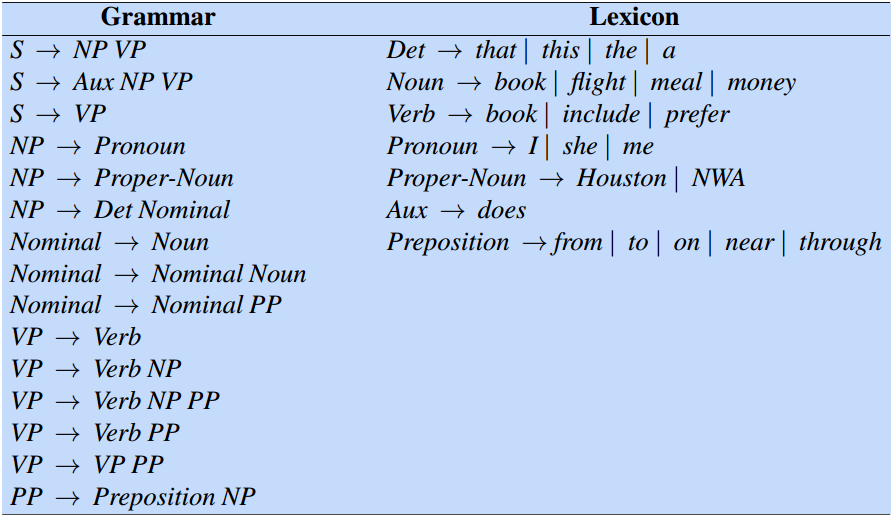

**Write a code which can take as input a phrase or sentence and return the constituency tree in a file as well as visualize. In the lexicon part of the grammar, add rules for all the words in the corpus given below.**

**For evaluation, manually create the parsing trees for 10 sentences from the corpus below and check if your algorithm can successfully parse them.**

**In the following corpus, perform random displacements of words for 50% of sentences and then check whether parse trees could be generated.**

**Do you find any sentence with multiple parse trees in the corpus? If yes, please justify the reason for one such sentence.**

# **Corpus:**
The Bermuda Triangle is an area in the western Atlantic Ocean. It is between Florida, Puerto Rico, and Bermuda. Many strange things have happened in this region. Boats, airplanes, and people have disappeared. Some say that this is just an urban legend. They try to explain the odd events with logic. Others think that there is something paranormal at work.In 1918 a US Navy ship called the USS Cyclops left Brazil. It was headed to Baltimore with 309 crew mates. It was also loaded with lots of metal ore. Some say it was overloaded. But inspection records show that the ship was properly loaded and secured. The last time witnesses saw the USS Cyclops was in Barbados, where it made an unscheduled stop. Neither the boat nor the crew were ever seen again.Many have tried to explain this disappearance. Some say the ship sank due to the heavy ore. Others say submarines or other warships sunk it. Some note that the ship had one bad engine. They claim that it made an unscheduled stop because it was taking on water. But we are all left to wonder, because no wreckage or remains of the ship or its crew were ever found. It just disappeared in the Bermuda Triangle. The US Navy records this as the largest loss of life outside of combat in its history.  Many incidents like these have happened in the Bermuda Triangle region. Boats, planes, and people go missing. Some believe that paranormal activity is at work. They think that the missing people and crafts are transported to another dimension. Others say UFOs are involved. Some think that the Lost City of Atlantis has something to do with it. But there is no evidence to support any of these theories.

## We can see that the tree is coming for all the ten test sentences taken from the corpus, however if we shuffled the words then the tree will not be parsed.

In [9]:
import nltk
from nltk import CFG
from nltk.parse.chart import ChartParser
import string
import pydot
from nltk.tree import Tree
import string
from PIL import Image
from io import BytesIO
import random

grammar = CFG.fromstring("""
S -> NP VP | S VP | Aux NP VP | NP VP Conj S | S Conj S | NP VP PP | Preposition Number S | Det S
NP -> Pronoun | Det Nominal | NP Conj NP  | ProperNoun PP | Number   | Nominal |
Nominal -> Noun | Nominal Noun | Nominal PP | Adj Nominal | ProperNoun  | Preposition Noun
VP -> Verb | Verb PP | VP Conj VP | Aux VP | VP Adverb | VerbClause | Adverb Det | Verb Det NP
PP -> Preposition NP | Adj Noun | Pronoun Adj Preposition Noun
VerbClause -> Verb NounPhrase | Verb Nominal

Det -> 'that' | 'this' | 'the' | 'a' | 'an' | 'many' | 'some' | 'lots' | 'each' | 'these' | 'those' | 'its'
Noun -> 'legend' | 'events' | 'work' | 'ship' | 'mates' | 'ore' | 'logic'  | 'crew'| 'book' | 'flight' | 'meal' | 'money' | 'area' | 'region' | 'atlantic'|'crew' | 'mates' | 'witnesses' | 'wreckage' | 'triangle' | 'ocean' | 'ship' | 'stop' | 'city' | 'dimension' | 'metal' | 'ore' | 'boats' | 'airplanes' | 'people' | 'things' | 'events' | 'logic' | 'disappearance' | 'navy' | 'crew mates' | 'legend' | 'cyclops' | 'brazil' | 'baltimore' | 'barbados' | 'us navy' | 'uss cyclops' | '1918' | 'brazilian' | 'barbadian' | 'others' | 'submarines' | 'warships' | 'life' | 'combat' | 'history' | 'planes' | 'ufos' | 'theories' | 'incidents' | 'loss' | 'crafts' | 'inspection' | 'records' | 'time' | 'note' | 'engine' | 'boat' | 'remains' | 'witness' | 'largest' | 'loss' | 'life' | 'outside' | 'combat' | 'bermuda' | 'atlantis' | 'ufos' | 'lost' | 'last' | 'all' | 'water' | 'evidence' | 'activity'|'florida'| 'puerto'| 'rico'|'uss'|'us'
Verb -> 'say' | 'try' | 'think' | 'explain' | 'left' | 'was' | 'headed' | 'loaded' | 'book' | 'include' | 'prefer' | 'happen' | 'loaded' | 'work' | 'happened' | 'disappeared' | 'disappear' | 'try' | 'think' | 'explain' | 'say' | 'leave' | 'is' | 'was' | 'head' | 'load' | 'sink' | 'go' | 'miss' | 'have' | 'called' | 'left' | 'headed' | 'sank' | 'was' | 'tried' | 'due' | 'show' | 'believe' | 'support' | 'saw' | 'made' | 'are' | 'claim' | 'taking' | 'note' | 'involved' | 'do' | 'transported' | 'seen' | 'found' | 'sunk' | 'had' | 'wonder'
Pronoun -> 'I' | 'she' | 'me' | 'it' | 'they' | 'we' | 'he' | 'others' | 'something' | 'neither' | 'where' | 'there'
ProperNoun -> 'USS Cyclops' | 'Brazil' | ' Baltimore' | 'US Navy'| 'Houston' | 'NWA' | 'Florida' | 'Bermuda' | 'Puerto' | 'Rico' | 'US' | 'Brazil' | 'Baltimore' | 'Barbados' | 'USS Cyclops' | 'Atlantic' | 'Triangle' | 'Ocean' | 'USS' | 'Cyclops' | 'Atlantis' | 'Bermuda'
Aux -> 'does' | 'did' | 'is' | 'was' | 'are' | 'has'|'were'
Conj -> 'and' | 'or' | 'but' | 'nor'|'as' | 'that'
Adverb -> 'quickly' | 'silently' | 'very' | 'just' | 'often' | 'also' | 'properly' | 'ever'|'other'
Number -> '309' | '1918'
Preposition -> 'from' | 'to' | 'of' | 'on' | 'near' | 'through' | 'in' | 'between' | 'with' | 'at' | 'about' | 'for' | 'because' | 'due'
Adj -> 'urban' | 'paranormal' | 'odd' | 'just' | 'heavy' | 'lots' | 'metal' | 'western' | 'Atlantic' | 'unscheduled' | 'paranormal' | 'odd' | 'heavy' | 'strange' | 'urban' | 'Brazilian' | 'Barbadian' | 'unusual' | 'unexpected' | 'bad' | 'properly' | 'overloaded' | 'secured' | 'largest' | 'missing' | 'one' | 'another' | 'no' | 'any'|'like'|'again'
""")

def tree_to_dot(tree):
    """Convert a tree to DOT format for visualization."""
    def add_edges(node, graph, parent=None):
        if isinstance(node, Tree):
            node_name = f'{node.label()}_{id(node)}'
            graph.add_node(pydot.Node(node_name, label=node.label()))
            if parent:
                graph.add_edge(pydot.Edge(parent, node_name))
            for child in node:
                add_edges(child, graph, node_name)
        else:
            node_name = f'{node}_{id(node)}'
            graph.add_node(pydot.Node(node_name, label=node))
            if parent:
                graph.add_edge(pydot.Edge(parent, node_name))

def save_tree_to_file(tree, filename):
    """Save the parse tree to a PNG file."""
    try:
        dot_data = tree_to_dot(tree)
        graph = pydot.graph_from_dot_data(dot_data)[0]
        graph.write_png(filename)
    except Exception as e:
        print(f"Error saving tree to file: {e}")

def shuffle_words_in_corpus(corpus):
    """Shuffle words in 50% of the sentences in the corpus."""
    shuffled_corpus = []
    for i, sentence in enumerate(corpus):
        if i % 2 == 0:
            words = preprocess_sentence(sentence).split()
            random.shuffle(words)
            shuffled_sentence = ' '.join(words)
            shuffled_corpus.append(shuffled_sentence)
        else:
            shuffled_corpus.append(sentence)
    return shuffled_corpus

# initializing my parser with the created grammar
parser = ChartParser(grammar)

def my_parse_sentence(sentence):
    words = sentence.split()
    grammar_vocab = set(grammar._lexical_index.keys())
    missing_words = [word for word in words if word not in grammar_vocab]
    if missing_words:
        print(f"Missing words in grammar: {missing_words}")
        return None
    try:
        trees = list(parser.parse(words))
        if not trees:
            print(f"No parse trees found for sentence: {sentence}")
        return trees
    except ValueError as e:
        print(f"Error during parsing: {e}")
        return None

def preprocess_sentence(sentence):
    sentence = sentence.translate(str.maketrans("", "", string.punctuation))
    return sentence.lower()

def shuffle_words_in_sentence(sentence):

    # Split the sentence into words
    words = sentence.split()
    random.shuffle(words)
    return ' '.join(words)

my_corpus = [
    "The Bermuda Triangle is an area in the western Atlantic Ocean.",    "It is between Florida, Puerto, Rico and Bermuda.",
    "Many strange things have happened in this region.",    "Boats airplanes and people have disappeared.",
    "Some say that this is just an urban legend.",    "They try to explain the odd events with logic.",
    "Others think that there is something paranormal at work.",    "In 1918 a US Navy ship called the USS Cyclops left Brazil.",
    "It was headed to Baltimore with 309 crew mates.",    "It was also loaded with lots of metal ore."
]

print("For the default corpus\n")
# generating trees on the given corpus
parsed_sentences = {}
for sentence in my_corpus:
    preprocessed_sentence = preprocess_sentence(sentence)
    trees = my_parse_sentence(preprocessed_sentence)
    if trees:
        print(f"Tree generated for the sentence:\n{sentence}\n")
        parsed_sentences[sentence] = trees[0]

        # uncomment the below line to save the tree to text format
        # save_tree_to_file(trees[0], 'tree.txt')
        # uncomment the below line to print tree
        trees[0].pretty_print()
    else:
        print(f"Failed to parse: {sentence}")

# shuffling the sentence
ind = random.sample(range(10), 5)
for i in ind:
    sentence = my_corpus[i]
    shuffled_sentence = shuffle_words_in_sentence(sentence)
    my_corpus[i]= shuffled_sentence

print("For the shuffled corpus\n")
# generating trees on the 50% shuffled corpus
parsed_sentences = {}
for sentence in my_corpus:
    preprocessed_sentence = preprocess_sentence(sentence)
    trees = my_parse_sentence(preprocessed_sentence)
    if trees:
        print(f"Tree generated for the sentence:\n{sentence}\n")
        parsed_sentences[sentence] = trees[0]

        # uncomment the below line to save the tree to text format
        # save_tree_to_file(trees[0], 'tree.txt')
        # uncomment the below line to print tree
        # trees[0].pretty_print()
    else:
        print(f"Failed to parse: {sentence}\n")

For the default corpus

Tree generated for the sentence:
The Bermuda Triangle is an area in the western Atlantic Ocean.

                                         S                                                          
        _________________________________|_________                                                  
       |                                           VP                                               
       |                       ____________________|_____________________                            
       |                      |    |                                     NP                         
       |                      |    |                                     |                           
       |                      |    |                                  Nominal                       
       |                      |    |                          ___________|_______________________    
       |                      |    |                      Nominal  

Taking the sentence **"Others think that there is something paranormal at work."** as example:

### Meaning 1: Main Clause + Embedded Clause

- **Structure**:
  - **Main Clause**: "Others think"
  - **Embedded Clause**: "that there is something paranormal at work"
    - **Embedded Clause Breakdown**:
      - **Subject**: "there" (dummy subject)
      - **Predicate**: "is something paranormal at work"
        - **Subject**: "something"
        - **Predicate**: "is at work"
          - **Modifier**: "paranormal" (describes "something")
          - **Prepositional Phrase**: "at work" (indicates the state or context of "something")

In this interpretation, the main clause indicates that "Others" hold a belief. The embedded clause specifies that their belief is that something paranormal is occurring.

### Interpretation 2: Focus on Paranormal

- **Structure**:
  - **Main Clause**: "Others think"
  - **Embedded Clause**: "that there is something paranormal at work"
    - **Embedded Clause Breakdown**:
      - **Subject**: "there" (dummy subject)
      - **Predicate**: "is [something paranormal [at work]]"
        - **Subject**: "something"
        - **Modifier**: "paranormal at work" (combines description of "something")

In this interpretation, the sentence also communicates that "Others" believe in something paranormal, with "at work" modifying "something."

### Justification

- **Structural Ambiguity**: The sentence's structure allows for different interpretations based on h


## We can see here that the accuracy for non-word error is much better than the accuracy for real-word error as real words can span more in the terms of the size of the possible words to be replaced.

In [11]:
import string
import random
from collections import Counter, defaultdict
import nltk
from nltk.util import bigrams, trigrams
from nltk.tokenize import word_tokenize
import numpy as np
nltk.download('punkt')

# Load corpus
def load_corpus(file_path):
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            _, sentence = line.split(maxsplit=1)
            sentences.append(sentence.strip().lower())
    return sentences

# Remove punctuation from a sentence
def remove_punctuation(sentence):
    # Define the translation table for removing punctuation
    translator = str.maketrans('', '', string.punctuation)
    return sentence.translate(translator)

# Enter the file path here
corpus_file_path = '/content/data_sen.txt'
sentences = load_corpus(corpus_file_path)

# Remove punctuation from each sentence
sentences = [remove_punctuation(sentence) for sentence in sentences]

# Print the first few sentences to verify
for i, sentence in enumerate(sentences[:5]):
    print(f"Sentence {i+1}: {sentence}")


Sentence 1: la cgt avait dailleurs critiqué lavis de la commission de garanties qui marquait selon elle le début dun processus sans fin dallongement de la durée de cotisation pour tous les salariés qui passerait ensuite à 42 ans en 2020
Sentence 2: pour ladressage rapide et professionnel de vos envois vous disposez dune gamme dimprimantes directes dadresses noir et blanc ou couleur ou dune étiqueteuse appliquant des étiquettes autoadhésives
Sentence 3: la vierge du seigneur sen alla ensuite terminer son uvre de paix
Sentence 4: présentation de celuici à plusieurs écoles primaires
Sentence 5: car chez le toutpetit une diarrhée aiguë nest jamais banale


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
def split_data(sentences, train_size=0.8):
    random.shuffle(sentences)
    split_index = int(len(sentences) * train_size)
    train_sentences = sentences[:split_index]
    test_sentences = sentences[split_index:]
    return train_sentences, test_sentences

train_sentences, test_sentences = split_data(sentences)


In [13]:
# Create n-gram models
def train_ngram_models(sentences):
    bigram_model = defaultdict(lambda: defaultdict(lambda: 0))
    trigram_model = defaultdict(lambda: defaultdict(lambda: 0))

    for sentence in sentences:
        tokens = word_tokenize(sentence)
        bigrams_list = list(bigrams(tokens))
        trigrams_list = list(trigrams(tokens))

        bigram_freq = Counter(bigrams_list)
        trigram_freq = Counter(trigrams_list)

        for (w1, w2), freq in bigram_freq.items():
            bigram_model[w1][w2] = freq

        for (w1, w2, w3), freq in trigram_freq.items():
            trigram_model[(w1, w2)][w3] = freq

    return bigram_model, trigram_model

bigram_model, trigram_model = train_ngram_models(train_sentences)


In [14]:
# Create a lexicon from training data
def create_lexicon(sentences):
    tokens = [word_tokenize(sentence) for sentence in sentences]
    return set([token for sublist in tokens for token in sublist])

lexicon = create_lexicon(train_sentences)

# Introduce non-word errors
def introduce_non_word_error(sentence, lexicon):
    tokens = word_tokenize(sentence)
    error_sentence = []
    for token in tokens:
        if token in lexicon:
            error_sentence.append(token)
        else:
            if random.random() < 0.5:  # 50% chance to introduce an error
                error_sentence.append(token + random.choice(['x', 'y', 'z']))  # Simple random error
            else:
                error_sentence.append(token)
    return ' '.join(error_sentence)

# Introduce real-word errors
def introduce_real_word_error(sentence, lexicon):
    tokens = word_tokenize(sentence)
    error_sentence = []
    for token in tokens:
        if token in lexicon:
            similar_words = [w for w in lexicon if w != token]
            if similar_words and random.random() < 0.5:  # 50% chance to introduce an error
                error_sentence.append(random.choice(similar_words))
            else:
                error_sentence.append(token)
        else:
            error_sentence.append(token)
    return ' '.join(error_sentence)


In [15]:
# Function to calculate perplexity
def calculate_perplexity(model, text, n):
    tokens = word_tokenize(text)
    if len(tokens) < n:
        return float('inf')

    perplexity = 1
    if n == 2:
        for i in range(len(tokens) - 1):
            perplexity *= (model[tokens[i]][tokens[i+1]] + 1) / (sum(model[tokens[i]].values()) + len(lexicon))
    elif n == 3:
        for i in range(len(tokens) - 2):
            perplexity *= (model[(tokens[i], tokens[i+1])][tokens[i+2]] + 1) / (sum(model[(tokens[i], tokens[i+1])].values()) + len(lexicon))

    return perplexity ** (1 / len(tokens))

# Function to correct spelling using a model
def correct_spelling(sentence, model, n):
    tokens = word_tokenize(sentence)
    corrected_sentence = []

    if n == 2:
        for i in range(len(tokens)):
            if i == 0:
                corrected_sentence.append(tokens[i])
            else:
                candidates = [(tokens[i], model[tokens[i-1]][tokens[i]])]
                best_candidate = min(candidates, key=lambda x: x[1])[0]
                corrected_sentence.append(best_candidate)
    elif n == 3:
        for i in range(len(tokens)):
            if i < 2:
                corrected_sentence.append(tokens[i])
            else:
                candidates = [(tokens[i], model[(tokens[i-2], tokens[i-1])][tokens[i]])]
                best_candidate = min(candidates, key=lambda x: x[1])[0]
                corrected_sentence.append(best_candidate)

    return ' '.join(corrected_sentence)


In [ ]:
# Function to evaluate performance on a subset
def evaluate_performance(sentences, model, n, is_real_word_error):
    correct = 0
    total = len(sentences)

    for sentence in sentences:
        if is_real_word_error:
            error_sentence = introduce_real_word_error(sentence, lexicon)
        else:
            error_sentence = introduce_non_word_error(sentence, lexicon)

        corrected_sentence = correct_spelling(error_sentence, model, n)

        if corrected_sentence == sentence:
            correct += 1

    accuracy = correct / total
    return accuracy

# Evaluate performance on the subset
accuracy_non_word_bigram = evaluate_performance(test_sentences, bigram_model, 2, is_real_word_error=False)
accuracy_real_word_bigram = evaluate_performance(test_sentences, bigram_model, 2, is_real_word_error=True)
accuracy_non_word_trigram = evaluate_performance(test_sentences, trigram_model, 3, is_real_word_error=False)
accuracy_real_word_trigram = evaluate_performance(test_sentences, trigram_model, 3, is_real_word_error=True)

print("Subset Accuracy for non-word errors (bigram):", accuracy_non_word_bigram)
print("Subset Accuracy for real-word errors (bigram):", accuracy_real_word_bigram)
print("Subset Accuracy for non-word errors (trigram):", accuracy_non_word_trigram)
print("Subset Accuracy for real-word errors (trigram):", accuracy_real_word_trigram)


Subset Accuracy for non-word errors (bigram): 0.34285714285714286
Subset Accuracy for real-word errors (bigram): 0.004511278195488722
Subset Accuracy for non-word errors (trigram): 0.3443609022556391
Subset Accuracy for real-word errors (trigram): 0.0035087719298245615
